# Studying Spectral Splits with `NuGas`

## Huaiyu Duan (University of New Mexico)

## Two-flavor, homogeneous and isotropic `NuGas` model

Following the examples in `bipolar.ipynb`, we now demonstrate how to use `nugas.f2i` to compute the flavor oscillations in homogneous and isotropic neutrino gases in the two flavor approximation.  

Like the bipolar system, the equation of motion (EoM) for the polarization vector $\mathrm{P}_\omega$ of the neutrino of oscillation frequency $\omega$ is:
$$ \frac{\mathrm{d}}{\mathrm{d} t} \mathbf{P}_\omega = \mathbf{H}_\omega \times  \mathbf{P}_\omega
= (-\eta\omega\mathbf{B} + \lambda\mathbf{L} + \mu \mathbf{D})\times \mathbf{P}_\omega, $$
except now $\omega$ is a continuous spectrum so that the net flavor polarization is
$$ \mathbf{D} = \int g_\omega \mathbf{P}_\omega\,\mathrm{d}\omega. $$ 

It is convenient to use the `mesh` function in `nugas.misc.quadrature` to perform the integral over $\omega$ numerically. `mesh` produces both the abscissas `x` and weights `w` for a given range [`a`, `b`] and the quadrature rule. The integral of an arbirary function $f(x)$ can be approximated as
$$ \int_a^b f(x)\,\mathrm{d}x \approx \sum_{i=0}^{n-1} f(x_i) w_i. $$

In [1]:
import numpy as np
from nugas.misc.quadrature import mesh, RULES

# numerical integration of sin(x) on [0, π] with different rules
n = 21 # number of points to use
for rule in RULES:
    x, w = mesh(0, np.pi, n, rule=rule)
    val = np.sin(x) @ w
    print(f"{rule} : result = {val}, error = {val-2}.")

midpoint : result = 2.0018662227143174, error = 0.001866222714317356.
trapezoid : result = 1.9958859727087146, error = -0.004114027291285405.
simpson : result = 2.000006784441801, error = 6.784441800800067e-06.
simpson2 : result = 2.000031839147014, error = 3.1839147013990043e-05.
chebyshev : result = 1.9999909622927328, error = -9.037707267234296e-06.
legendre : result = 2.0000000000000018, error = 1.7763568394002505e-15.


The default composite [`midpoint` rule](https://en.wikipedia.org/wiki/Midpoint_method) divides [`a`, `b`] into `n` equal-size bins with the abscissas in the centers of the bins, while the [`trapezoid` rule](https://en.wikipedia.org/wiki/Trapezoidal_rule) divdes [`a`, `b`] into `n`-1 bins with the abscissas on the edges of bins including the end points `a` and `b`. The [`simpson` rule and its alternative `simpson2`](https://en.wikipedia.org/wiki/Simpson%27s_rule) have the same abscissas as the `trapezoid` rule but are more accurate if the integrand is smooth. `simpson2` works better than `simpson` if the integrand has narrow peaks in the middle. 

For a continuous ELN spectrum $g_\omega$, the `weights` parameter of `NuGas` should be an array with `weights[i] = g[i] * w[i]`, where `g[i]` is the ELN at `omega[i]` with `omega` and `w` being the abscissas and weights produced by `mesh`.

## Spectral split

Let's consider one of the examples in [arXiv:0705.1830](https://arxiv.org/abs/0705.1830). In this example, 
$$ g_\omega = \begin{cases}
1/2\omega_0 & \mathrm{if}\, 0\leq \omega\leq 2\omega_0, \\
0 & \mathrm{otherwise},
\end{cases} $$
where $\omega_0$ is the energy scale of the problem. We will measure everything in $\omega_0$ by setting it to 1. The strength of the neutrino coupling is $\mu(t)=\mu_0 \exp(-t/\tau)$ with $\omega_0/\tau=0.03$. At $t=0$, all the polarization vectors are $\mathbf{P}_\omega(t=0) = [1/\sqrt{2}, 0, 1/\sqrt{2}]$.

In [2]:
from nugas.f2i import NuGas

# generate the weights
g = lambda omega: 0.5 # ELN function
Nw = 201 # number of frequencies
omegas, weights = mesh(0, 2, Nw, rule='simpson') # generate abscissas
weights *= g(omegas) # weights

# time depend neutrino self-coupling strength
mu0 = 100 # initial mu
tau = 1/0.03 # decay timescale of mu
mu = lambda t: mu0 * np.exp(-t/tau) 

# initialize the model
theta = np.arcsin(0.05)/2 # mixing angle
P0 = [np.sqrt(1 - 0.5**2), 0, 0.5] # initial polarization vector
P_ini = np.empty((Nw, 3), dtype=np.double)
P_ini[:,:] = P0
gas = NuGas(omegas=omegas, weights=weights, P_ini=P_ini, theta=theta, mu=mu, imo=True)

# evolve the model
Nt = 301 # number of time points
tf = -tau * np.log(0.1/mu0) # final time
tt = np.linspace(0, tf, Nt)[1:] # time points, drop t=0
t_fin, P_fin = gas.evolve(tt)

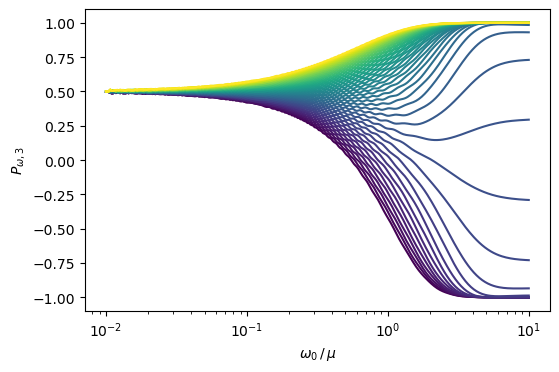

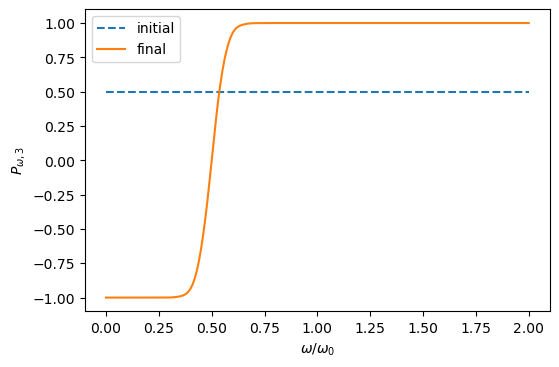

In [3]:
import matplotlib.pyplot as plt

# plot of P_3 as functions of mu
cm = plt.cm.get_cmap('viridis') # color map
plt.figure(dpi=100)
for wi in range(0, Nw, 4):
    plt.semilogx(1/mu(gas.t), gas.P[:,wi,2], color=cm(wi/(Nw-1)))
plt.ylabel('$P_{\omega,3}$')
plt.xlabel('$\omega_0\,/\,\mu$')
plt.show()

# plot of final P_3 as a function of omega
plt.figure(dpi=100)
plt.plot(omegas, P_ini[:,2], '--', label='initial')
plt.plot(omegas, P_fin[:,2], label="final")
plt.ylabel('$P_{\omega,3}$')
plt.xlabel('$\omega/\omega_0$')
plt.legend()
plt.show()

## Adiabatic precession solution

While the spectral split phenomenon may seem mysterious at first sight, its interpretation is remarkably simple. In the absence of the ordinary matter ($\lambda=0$), the equation of motion of $\mathbf{P}_\omega$ has an axial symmetry about $\mathbf{B}$. Therefore, one can look for a pure precession solution as in the bipolar system [[arXiv:astro-ph/0703776](https://arxiv.org/abs/astro-ph/0703776)]. While we pointed out how such a pure precession solution can lead to spectral splits when the neutrino densities decrease slowly [[arXiv:astro-ph/0606616](https://arxiv.org/abs/astro-ph/0606616)], it was Raffelt and Smirnov who found the following consistency equations from which one can solve for the pure precession solution [[arXiv:0705.1830](https://arxiv.org/abs/0705.1830)] (with some notation changes):
$$\mu\int \frac{g_\omega \mathrm{d}\omega}{\sqrt{[(\Omega-\eta\omega)+\mu D_3]^2 + (\mu D_\perp)^2}} = 1 $$
and 
$$\mu\int \frac{\eta\omega g_\omega \mathrm{d}\omega}{\sqrt{[(\Omega-\eta\omega)+\mu D_3]^2 + (\mu D_\perp)^2}} = \Omega. $$
Here $\Omega$ is the collective frequency with which all $\mathbf{P}_\omega$ rotate about $\mathbf{B}$. For given values of $D_3=\mathbf{D}\cdot\mathbf{B}$ (which is conserved) and $\mu$, one can solve $\Omega$ and $D_\perp$, the component of $\mathbf{D}$ perpendicular to $\mathbf{e}_3$ from the above equations. 

In a pure precession solution, all $\mathbf{P}_\omega$ lie in the same plane that passes through the axis along $\mathbf{B}$. Their components that are parallel and normal to $\mathbf{B}$ can be written as
$$ P_3 = \frac{[(\Omega-\eta\omega)+\mu D_3] g_\omega}{\sqrt{[(\Omega-\eta\omega)+\mu D_3]^2 + (\mu D_\perp)^2}} $$
and
$$ P_\perp = \frac{\mu D_\perp g_\omega}{\sqrt{[(\Omega-\eta\omega)+\mu D_3]^2 + (\mu D_\perp)^2}}. $$

This pure precession solution can be solved by using the function `adsol()` in `nugas.f2i` which accepts the following arguments:
- `D3`: $D_3$.
- `mu` : a single value or a list of $\mu$ at which the adiabatic solutions are desired.
- `omegas`: a list `Nw` vaccum oscillation frequencies.
- `weights`: a list of weights for the polarization vectors.
- `imo`: whether the neutrino has the inverted mass order. Default is False.
- `D1_guess`: initial guess for $D_\perp$. A default value is used when it is not given.
- `Omega_guess`: initial guess for $\Omega$. A default value is used when it is not given.
- `root_kargs`: a dictionary of keyword arguments to be passed to `scipy.optimize.root`. It is empty by default.

If successful, `adsol()` will return a list that gives $D_1$, $\Omega$, $P_{\perp}$, and $P_{3}$. 

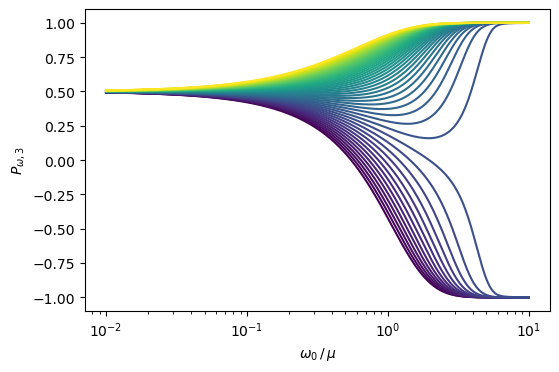

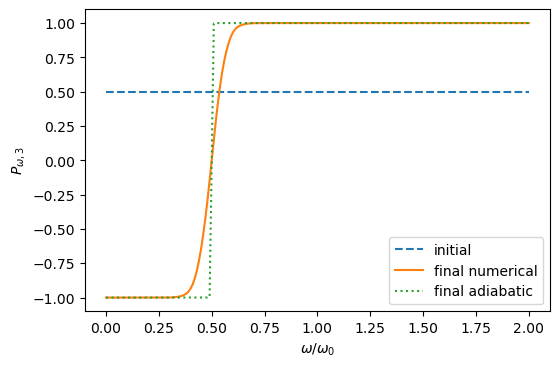

In [4]:
from nugas.f2i import adsol

# compute adiabatic solutions for various mu's
mus = np.logspace(2, -1, Nt) # values of mu to compute the precession solution 
D3 = 0.5 # conserved lepton number
D1, Omega, Pad1, Pad3 = adsol(D3, mus, omegas, weights, imo=True, root_kargs={"options": {"maxfev": 1000}})

# plot P_3 for various omegas
plt.figure(dpi=100)
for wi in range(0, Nw, 4):
    plt.semilogx(1/mus, Pad3[:,wi], color=cm(wi/(Nw-1)))
plt.ylabel('$P_{\omega,3}$')
plt.xlabel('$\omega_0\,/\,\mu$')
plt.show()

# plot of final P_3 as a function of omega
plt.figure(dpi=100)
plt.plot(omegas, P_ini[:,2], '--', label='initial')
plt.plot(omegas, P_fin[:,2], label="final numerical")
plt.plot(omegas, Pad3[-1,:], ':', label="final adiabatic")
plt.ylabel('$P_{\omega,3}$')
plt.xlabel('$\omega/\omega_0$')
plt.legend()
plt.show()

## Spectral swaps in the single-angle model

When neutrinos are initially in different flavors in the same energy range, spectral splits lead to the swaps of neutrino energy spectra which were first discussed in [arXiv:astro-ph/0606616](https://arxiv.org/abs/astro-ph/0606616). The neutrino oscillations in the single-angle model can be studied with `nugas.f2i` by treating the radius as time.

In the following example, we take the initial energy spectra of the neutrinos to be of the Dirac-Fermi form: 
$$ f^0_\nu(E) \propto \frac{L}{\langle E_\nu\rangle} \frac{E^2}{\exp(E/T_\nu - \xi)+1} $$
as in [arXiv:astro-ph/0606616](https://arxiv.org/abs/astro-ph/0606616) with $T_{\nu_e}=2.76$ MeV, $T_{\bar{\nu}_e}=4.01$ MeV, $T_{\nu_x}=T_{\bar{\nu}_x}=6.26$ MeV, and $\xi=3$. We will use simplified matter potential $\lambda(r)=\lambda_0(R/r)^3$ and neutrino $\mu(r) = \mu_0 (R/r)^4$ with $R=10$ km, $\lambda_0=40$ km$^{-1}$ and $\mu_0=10^5$ km$^{-1}$, respectively. Here $\mu$ is defined to be $\sqrt{2}G_\mathrm{F}$ times the (effective) $\nu_e$ density. Because the $\nu_e$ and $\nu_x$ of the same energy $E$ have the same $\omega$ (and so are $\bar\nu_e$ and $\bar\nu_x$), the `weights` should be computed from the ELN spectrum
$$ g_\omega = \begin{cases}
f^0_{\nu_e}(E) - f^0_{\nu_x}(E) & \text{for neutrinos}, \\
-f^0_{\bar\nu_e}(E) + f^0_{\bar\nu_x}(E) & \text{for antineutrinos}.
\end{cases} $$

We will measure everything in km.

In [5]:
from nugas.misc.constants import hbarc 

theta = 0.15 # mixing angle
dmsqr = 2.5e-3 * 1e-12 # mass-squared difference in MeV^2

# energy bins
Ne = 300 # number of energy bins for each neutrino species
Emax = 60 # maximum neutrino energy (in MeV) to include
Emin = 0 # minimum energy
Es, ws = mesh(Emin, Emax, Ne) # energy bins with midpoint rule

# frequency bins
omegas = np.empty(2*Ne, dtype=np.double) 
omegas[:Ne] = (0.5 * dmsqr / hbarc) / Es # neutrino oscillation frequencies in km^-1
omegas[Ne:] = -omegas[:Ne] # antineutrino section

# enegy spectra
f = lambda E, T: E**2 / (np.exp(E/T-3) + 1) # spectrum function
fnue = f(Es, 2.76) # nu_e spectrum
fnue /= fnue @ ws # normalized to 1
Enue = Es @ (fnue * ws) # average nu_e energy
fanue = f(Es, 4.01) # anti-nu_e spectrum
fanue /= fanue @ ws # normalized to 1
Eanue = Es @ (fanue * ws) # average anti-nu_e energy
fanue *= Enue/Eanue # now normalized to E_nue/E_anue
fnux = f(Es, 6.26) # nu_x and anti-nu_x spectra
fnux /= fnux @ ws # normalized to 1
Enux = Es @ (fnux * ws) # average nu_x energy
fnux *= Enue/Enux # normalized to E_nue/E_nux

# weights
weights = np.empty(2*Ne, dtype=np.double)
weights[:Ne] = (fnue - fnux) * ws
weights[Ne:] = (fnux - fanue) * ws

In [6]:
# initialize the models
R = 10 # radius of the neutrino sphere
lam0 = 40 # initial λ
mu0 = 1e5 # initial μ
lam = lambda r: lam0 * (R/r)**3 # matter potential
mu = lambda r: mu0 * (R/r)**4 # neutrino potential
# single-angle model with the normal mass ordering
sa_no = NuGas(t_ini=R, omegas=omegas, weights=weights, theta=theta, Hmat=lam, mu=mu) 
# single-angle model with the inverted mass ordering
sa_io = NuGas(t_ini=R, omegas=omegas, weights=weights, theta=theta, Hmat=lam, mu=mu, imo=True)

# evolve the models
rf = 250 # final radius
r_no, P_no = sa_no.evolve(rf)
r_io, P_io = sa_io.evolve(rf)

After computing the models, the neutrino energy spectra  of the neutrinos at radius $r$ can be obtained in the following way:
$$ f_{\nu_e}(r, E) = \left(\frac{f^0_{\nu_e}(E)+f^0_{\nu_x}(E)}{2}\right) P_3(r, \omega)
+ \left(\frac{f^0_{\nu_e}(E)-f^0_{\nu_x}(E)}{2}\right) P_3(r, \omega), $$
$$ f_{\nu_x}(r, E) = \left(\frac{f^0_{\nu_e}(E)+f^0_{\nu_x}(E)}{2}\right) P_3(r, \omega)
- \left(\frac{f^0_{\nu_e}(E)-f^0_{\nu_x}(E)}{2}\right) P_3(r, \omega), $$
$$ f_{\bar\nu_e}(r, E) = \left(\frac{f^0_{\bar\nu_e}(E)+f^0_{\bar\nu_x}(E)}{2}\right) P_3(r, -\omega)
+ \left(\frac{f^0_{\bar\nu_e}(E)-f^0_{\bar\nu_x}(E)}{2}\right) P_3(r, -\omega), $$
and
$$ f_{\bar\nu_x}(r, E) = \left(\frac{f^0_{\bar\nu_e}(E)+f^0_{\bar\nu_x}(E)}{2}\right) P_3(r, -\omega)
- \left(\frac{f^0_{\bar\nu_e}(E)-f^0_{\bar\nu_x}(E)}{2}\right) P_3(r, -\omega), $$
where $\omega=|\delta m^2|/2E$.

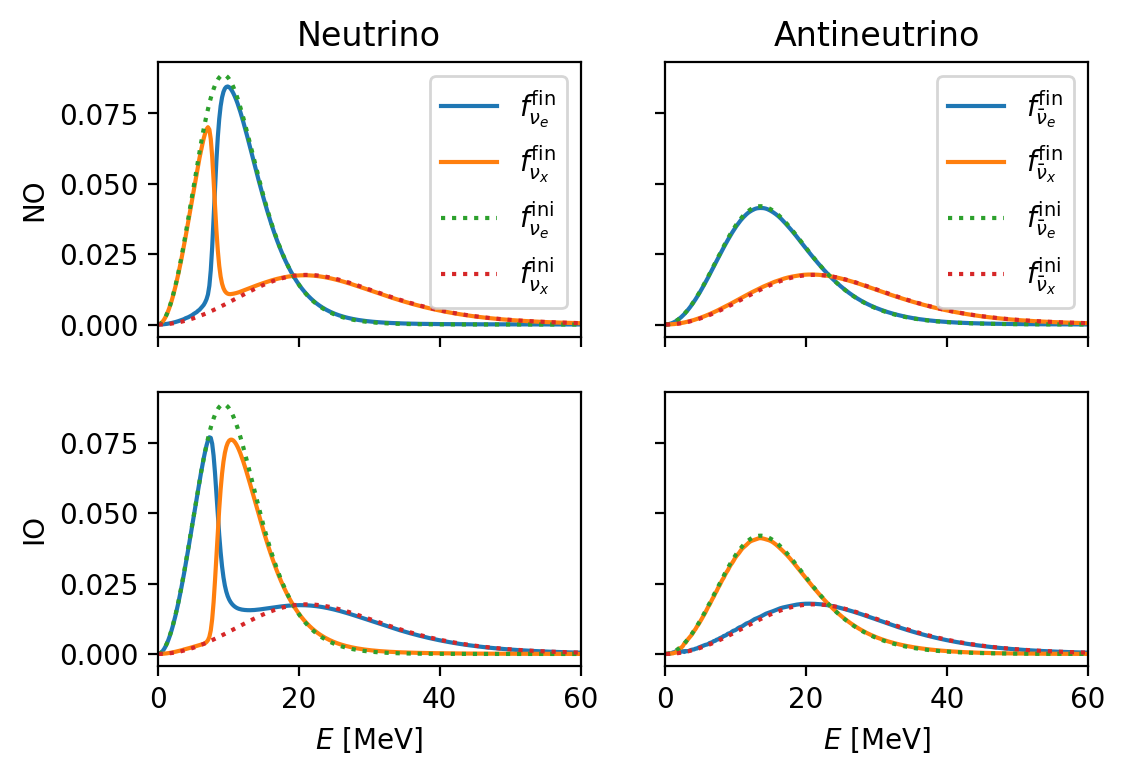

In [7]:
# plot neutrino energy spectra
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, dpi=200)

# NO, neutrino
fnu0 = 0.5 * (fnue + fnux)
fnu1_no = 0.5 * (fnue - fnux) * P_no[:Ne, 2]
axs[0,0].plot(Es, fnu0 + fnu1_no, label=r'$f_{\nu_e}^\mathrm{fin}$') # final nu_e
axs[0,0].plot(Es, fnu0 - fnu1_no, label=r'$f_{\nu_x}^\mathrm{fin}$') # final nu_x
axs[0,0].plot(Es, fnue, ":", label=r'$f_{\nu_e}^\mathrm{ini}$') # initial nu_e
axs[0,0].plot(Es, fnux, ":", label=r'$f_{\nu_x}^\mathrm{ini}$') # initial nu_x
axs[0,0].set_ylabel('NO')
axs[0,0].legend()
axs[0,0].set_title('Neutrino')

# IO, neutrino
fnu1_io = 0.5 * (fnue - fnux) * P_io[:Ne, 2]
axs[1,0].plot(Es, fnu0 + fnu1_io) # final nu_e
axs[1,0].plot(Es, fnu0 - fnu1_io) # final nu_x
axs[1,0].plot(Es, fnue, ":") # initial nu_e
axs[1,0].plot(Es, fnux, ":") # initial nu_x
axs[1,0].set_ylabel('IO')
axs[1,0].set_xlabel('$E$ [MeV]')
axs[1,0].set_xlim(0, 60)

# NO, antineutrino
fanu0 = 0.5 * (fanue + fnux)
fanu1_no = 0.5 * (fanue - fnux) * P_no[Ne:,2]
axs[0,1].plot(Es, fanu0 + fanu1_no, label=r'$f_{\bar\nu_e}^\mathrm{fin}$') # final anti-nu_e
axs[0,1].plot(Es, fanu0 - fanu1_no, label=r'$f_{\bar\nu_x}^\mathrm{fin}$') # final anti-nu_x
axs[0,1].plot(Es, fanue, ":", label=r'$f_{\bar\nu_e}^\mathrm{ini}$') # initial anti-nu_e
axs[0,1].plot(Es, fnux, ":", label=r'$f_{\bar\nu_x}^\mathrm{ini}$') # initial anti-nux
axs[0,1].legend()
axs[0,1].set_title('Antineutrino')

# IO, antineutrino
fanu1_io = 0.5 * (fanue - fnux) * P_io[Ne:,2] 
axs[1,1].plot(Es, fanu0 + fanu1_io) # final anti-nu_e
axs[1,1].plot(Es, fanu0 - fanu1_io) #final anti-nu_x
axs[1,1].plot(Es, fanue, ":") # initial anti-nu_e
axs[1,1].plot(Es, fnux, ":") # initial anti-nu_x
axs[1,1].set_xlabel('$E$ [MeV]')
axs[1,1].set_xlim(0, 60)

plt.show()

## Acknowledgements

This material is based upon work supported by the U.S. Department of Energy, Office of Science, Office of Nuclear Physics under Award Number DE-SC-0017803.